<a href="https://colab.research.google.com/github/microprediction/timemachines/blob/main/chatgpt_skater_arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install statsmodels

In [ ]:
!pip install microprediction

### A "Skater" written by ChatGPT
(I admit this one took some trial and error)

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian fai

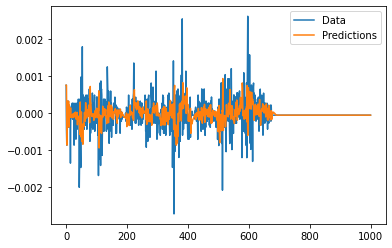

In [25]:
from datetime import datetime, timedelta
import pytz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from microprediction import MicroReader
from numpy.linalg import LinAlgError

# Set up reader and writer objects
reader = MicroReader()

# Define the skater function with a buffer of 15
def skater(y, s, k, a=None, t=None, e=1000, r=0.1):
    if len(s.get('history', [])) < 15:
        if len(s.get('history', [])) == 0:
            s['history'] = [y]
        x = [s['history'][-1]] * k
        x_std = [0] * k
    else:
        try:
            arima_order = (2, 0, 0)
            arima_model = sm.tsa.ARIMA(s['history'], order=arima_order)
            arima_result = arima_model.fit()
            x = arima_result.forecast(steps=k)[0]
            x_std = np.sqrt(arima_result.forecast(steps=k)[1])
        except LinAlgError:
            # Use the last value as the prediction
            x = [s['history'][-1]] * k
            x_std = [0] * k
    s['history'].append(y)
    s['history'] = s['history'][-15:]  # Keep last 15 observations
    return x, x_std, s

# Read the data
lagged_values = reader.get_lagged_values(name='finance-futures-gold-log-return.json', count=1000)
y = lagged_values[::-1]

# Generate predictions and submit them to the stream
s = {}
x = list()
for yi in y:
    xi, x_std, s = skater(y=yi, s=s, k=1, e=1000)
    x.append(xi)

# Create a plot of the data and predictions
ndx = list(range(len(x)))
plt.plot(ndx, y, label='Data')
plt.plot(ndx, x, label='Predictions')
plt.legend()
plt.show()
